# **Duke University**
* Course: AIPI590 (Deep Reinforcement Learning Applications)
* Fall 2022:

# * Final Project: Product recommender for E-commerce
* Dataset: RetailRocket
* Metric: AUC



# The RetailRocket Dataset

This dataset includes three files:
* (i) A file with behaviour data (events.csv)
* (ii) A file with item properties (itemproperties.сsv)
* (iii) A file describing the category tree (categorytree.сsv).
The data has been collected from a real-world ecommerce website. It is raw data, i.e. without any content transformations, however, all values are hashed due to confidential issues.

# Content

The behaviour data (events like clicks, add to carts, transactions) represents interactions that were collected over a period of 4.5 months. A visitor can make three types of events, namely: **“view”**, **“addtocart”** or **“transaction”**. The total events are 2,756,101, the views total 2,664,312, the addtocart 69,332 and 22,457 transactions from 1,407,580 unique visitors. For about 90% of events corresponding properties can be found in the “item_properties.csv” file.

# For example:
*  “1439694000000,1,view,100,” means visitorId = 1, clicked the item with id = 100 at 1439694000000 (Unix timestamp)
* “1439694000000,2,transaction,1000,234” means visitorId = 2 purchased the item 
with id = 1000 in transaction with id = 234 at 1439694000000 (Unix timestamp).

The "item properties" file (item_properties.csv), has 20,275,902 rows, i.e. different properties, describing 417,053 unique items. The File is divided into 2 files due to file size limitations. Since the property of an item can vary in time (e.g., price changes over time), every row in the file has corresponding timestamp. In other words, the file consists of concatenated snapshots for every week in the file with the behaviour data. However, if a property of an item is constant over the observed period, only a single snapshot value will be present in the file.
For example, we have three properties for single item and 4 weekly snapshots, like below:
> timestamp,itemid,property,value
1439694000000,1,100,1000
1439695000000,1,100,1000
1439696000000,1,100,1000
1439697000000,1,100,1000
1439694000000,1,200,1000
1439695000000,1,200,1100
1439696000000,1,200,1200
1439697000000,1,200,1300
1439694000000,1,300,1000
1439695000000,1,300,1000
1439696000000,1,300,1100
1439697000000,1,300,1100

**After snapshot merge it would looks like:**

> 1439694000000,1,100,1000
1439694000000,1,200,1000
1439695000000,1,200,1100
1439696000000,1,200,1200
1439697000000,1,200,1300
1439694000000,1,300,1000
1439696000000,1,300,1100

Because property=100 is constant over time, property=200 has different values for all snapshots, property=300 has been changed once.

Item properties file contain timestamp column because all of them are time dependent, since properties may change over time, e.g. price, category, etc. Initially, this file consisted of snapshots for every week in the events file and contained over 200 millions rows. We have merged consecutive constant property values, so it's changed from snapshot form to change log form. Thus, constant values would appear only once in the file. This action has significantly reduced the number of rows in 10 times.

All values in the “item_properties.csv” file excluding "categoryid" and "available" properties were hashed. Value of the "categoryid" property contains item category identifier. Value of the "available" property contains availability of the item, i.e. 1 means the item was available, otherwise 0. All numerical values were marked with "n" char at the beginning, and have 3 digits precision after decimal point, e.g., "5" will become "n5.000", "-3.67584" will become "n-3.675". All words in text values were normalized (stemming procedure: https://en.wikipedia.org/wiki/Stemming) and hashed, numbers were processed as above, e.g. text "Hello world 2017!" will become "24214 44214 n2017.000"

The category tree file has 1669 rows. Every row in the file specifies a child categoryId and the corresponding parent.
For example:

> Line “100,200” means that categoryid=1 has parent with categoryid=200

> Line “300,” means that categoryid hasn’t parent in the tree
Acknowledgements

Retail Rocket (retailrocket.io) helps web shoppers make better shopping decisions by providing personalized real-time recommendations through multiple channels with over 100MM unique monthly users and 1000+ retail partners over the world.

# Source: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset 


**If not accessig data files from Google drive, skip first two steps.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#%cd /content/drive/MyDrive/FinalProj/
%cd /content/drive/Othercomputers/My-MacBook-Air/590-Final-Project/

/content/drive/Othercomputers/My-MacBook-Air/590-Final-Project


**Import necessary libraries and dependicies**

In [3]:
import pandas as pd
import numpy as np

import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

**Verify you are in the correct folder(s).**

In [4]:
!ls


Amazon_final_project.ipynb  pop_dict.txt  RetailRocket_Final_Project.ipynb
Authors.md		    README.md	  Scripts
Datasets		    report.txt	  Take_Home_Project_2022F.pdf


##  Access and load the data for the "item-properties" files.

In [5]:
#PROJ_DIR = '/content/drive/MyDrive/FinalProj/RetailRocket/'
PROJ_DIR = 'Datasets/RetailRocket/'
items1 = pd.read_csv(PROJ_DIR + "item_properties_part1.csv.zip",compression='zip')
items2 = pd.read_csv(PROJ_DIR + "item_properties_part2.csv.zip",compression='zip')
events = pd.read_csv(PROJ_DIR + "events.csv.zip",compression='zip')
items = pd.concat([items1, items2])
items.sample(15)

,timestamp,itemid,property,value
3644954,1435460400000,409132,879,810323
8492241,1437879600000,419682,1036,769062 521441 769062
6521491,1431226800000,258992,364,415095
8431184,1437274800000,35412,663,1297729 n156.000 606827
7822540,1437879600000,128892,451,1141052 140719 553394
6507196,1431226800000,43483,710,1206543 n108.000 798006 190776
6441433,1436670000000,180239,available,1
4906253,1432436400000,69905,810,n36.000 1175087 n36.000 1175087 n36.000 424566
8741758,1432436400000,225444,available,1
4336018,1438484400000,3196,888,140639 378290


In [6]:
items.shape

(20275902, 4)

In [7]:
# Create list of visitors who made a purchase and the purchased items
customer_purchased = events[events.transactionid.notnull()].visitorid.unique()
purchased_items = []

for customer in customer_purchased:
    purchased_items.append(list(events.loc[(events.visitorid == customer) & (events.transactionid.notnull())].itemid.values))

In [8]:
purchased_items[:8]

[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044],
 [54058,
  284871,
  251130,
  268335,
  183049,
  261940,
  369093,
  370745,
  192990,
  277119,
  241716,
  283766,
  16417,
  217068,
  36372,
  68923,
  428015,
  69533,
  13520,
  385638,
  442871,
  136526,
  247862,
  93828,
  230911,
  382595,
  34853,
  216260,
  154812,
  445241,
  57702,
  347850,
  151855,
  226327,
  288525,
  51354,
  345994,
  170438,
  254301,
  266439,
  193718,
  388558,
  26745,
  184086,
  79956,
  252040,
  82232,
  309821,
  394518,
  462070,
  331980,
  353111,
  200527,
  235933,
  68532,
  358882,
  60012,
  29741,
  270487,
  163689,
  6913,
  156457,
  341578,
  163352,
  234493,
  135174,
  452481,
  241755,
  56323,
  210137,
  184397,
  285202,
  198690,
  195958,
  239210,
  71640,
  189108,
  369112,
  346186,
  211207,
  134330,
  257070,
  302239,
  459480,
  57577,
  1952

Function for showing items bought by the same customer.

In [9]:
def recommend_items(item_id, purchased_items):
    recommendation_list =[]
    for x in purchased_items:
        if item_id in x:
            recommendation_list +=x
    recommendation_list = list(set(recommendation_list) - set([item_id]))
    return recommendation_list

Recommend items when a visitor is views item_id = 404129

In [10]:
recommend_items(404129, purchased_items)

[222208,
 6913,
 56323,
 135174,
 211207,
 183049,
 288525,
 234255,
 285202,
 442131,
 36372,
 184086,
 226327,
 163352,
 394518,
 170262,
 16417,
 198690,
 34853,
 156457,
 54058,
 29741,
 257070,
 268335,
 151855,
 200242,
 241716,
 261940,
 247862,
 302391,
 82232,
 370745,
 445241,
 68923,
 309821,
 341578,
 346186,
 374092,
 184397,
 136526,
 200527,
 361554,
 79956,
 353111,
 241755,
 254301,
 215904,
 264801,
 442725,
 385638,
 57702,
 163689,
 239210,
 60012,
 372845,
 283766,
 195958,
 249207,
 26745,
 259964,
 277119,
 9087,
 452481,
 382595,
 93828,
 252040,
 94344,
 345994,
 270487,
 51354,
 85914,
 69533,
 235933,
 302239,
 195234,
 204209,
 332721,
 189108,
 68532,
 193718,
 134330,
 154812,
 216260,
 369093,
 170438,
 284871,
 266439,
 229577,
 347850,
 331980,
 388558,
 13520,
 23251,
 459480,
 210137,
 71640,
 369112,
 206809,
 192990,
 358882,
 214757,
 57577,
 217068,
 428015,
 462070,
 442871,
 251130,
 234493,
 230911]

In [11]:
events.head(10)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
5,1433224086234,972639,view,22556,NaN
6,1433221923240,810725,view,443030,NaN
7,1433223291897,794181,view,439202,NaN
8,1433220899221,824915,view,428805,NaN
9,1433221204592,339335,view,82389,NaN


# Load and Plot Data

event
addtocart        69332
transaction      22457
view           2664312
Name: event, dtype: int64


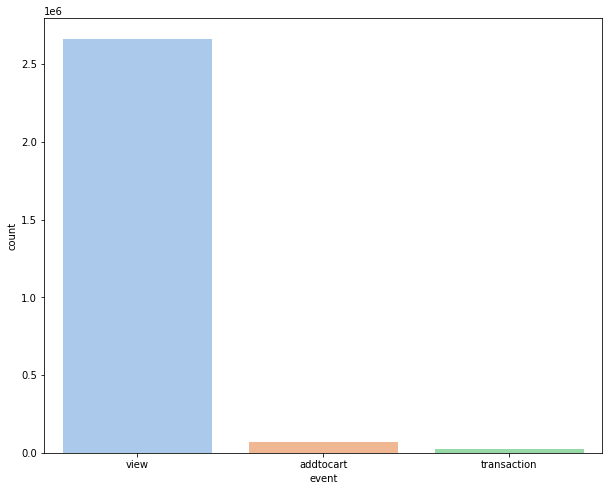

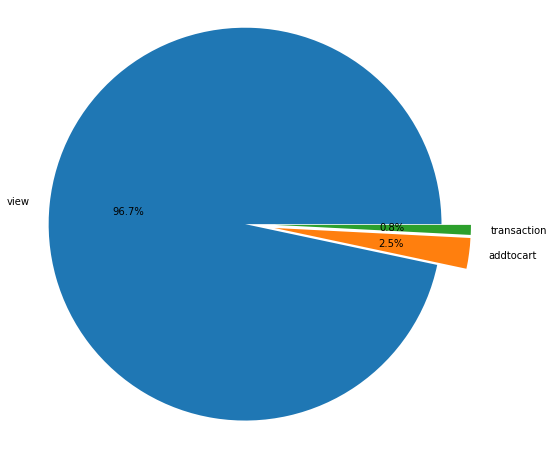

Total visitors: 2756101
Unique visitors: 1407580
items with categoryid and available as property: 9167412


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [12]:
%run 'Scripts/Retail_Rocket/preprocess.py' --data='Datasets/RetailRocket/'

## Data Preparation


In [27]:
%run 'Scripts/Retail_Rocket/split_data.py'

/content/drive/Othercomputers/My-MacBook-Air/590-Final-Project/Scripts/Retail_Rocket/split_data.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['rating'] = cate_enc.fit_transform(events_train.event)
/content/drive/Othercomputers/My-MacBook-Air/590-Final-Project/Scripts/Retail_Rocket/split_data.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train['visitorid'] = trans_cat_train['visitorid']
/content/drive/Othercomputers/My-MacBook-Air/590-Final-Project/Scripts/Retail_Rocket/spli

In [28]:
%run 'Scripts/Retail_Rocket/pop.py' --data='Datasets/RetailRocket'

0.0
1.0
2.0
3.0


In [30]:
%run 'Scripts/Retail_Rocket/replay_buffer.py'

   visitorid  itemid event        date
0     689859  421640  view  2015-05-03
1     935582  203248  view  2015-05-03
2     696326  194830  view  2015-05-03
3     131668  395045  view  2015-05-03
4     595484  129111  view  2015-05-03


# Modeling

## Non-Deep RL Model

Install LightFM to be used for modeling

In [16]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import necessary libraries for modeling

In [17]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from scipy.sparse import coo_matrix
from sklearn import preprocessing

In [18]:
events_train = pd.read_pickle('Datasets/RetailRocket/events_train.df')
events_test = pd.read_pickle('Datasets/RetailRocket/events_test.df')

n_users=len(np.unique(events_train['visitorid']))
n_items=len(np.unique(events_train['itemid']))

rate_matrix = dict()
rate_matrix['train'] = coo_matrix((events_train['rating'], (events_train['visitorid'], events_train['itemid'])), shape=(n_users,n_items))
rate_matrix['test'] = coo_matrix((events_test['rating'], (events_test['visitorid'], events_test['itemid'])), shape=(n_users,n_items))

In [19]:
model = LightFM(no_components=10, loss='warp')
model.fit(rate_matrix['train'], epochs=50, num_threads=10)

## Metric: Area Under ROC Curve (AUC)
AUC measures the likelihood that a random relevant item is ranked higher than a random irrelevant item. Higher the likelihood of this happening implies a higher AUC score meaning a better recommendation system.

We calculate this likelihood empirically based on the ranks given by the algorithm to all items — out of all possible pairs of type (relevant-item, non-relevant-item), AUC is a proportion of pairs where relevant-item was ranked higher than the irrelevant item from that pair.




https://drive.google.com/uc?id=1QE286jpRYXR4xlxjrgCufOCb1BvqnI5T

In [20]:
auc_score(model, rate_matrix['train'], num_threads=10).mean()

0.9973984

In [21]:
auc_score(model, rate_matrix['test'], num_threads=10).mean()

0.82256746

## Deep RL Model

In [22]:
ls

Amazon_final_project.ipynb  pop_dict.txt  RetailRocket_Final_Project.ipynb
Authors.md                  README.md     Scripts/
Datasets/                   report.txt    Take_Home_Project_2022F.pdf


In [23]:
! pip install pandas trfl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
!python 'Scripts/Retail_Rocket/SA2C.py' --model=GRU --data='Datasets/RetailRocket' --epoch=5

Scripts/Retail_Rocket/SA2C.py:88: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  tf.compat.v1.nn.rnn_cell.GRUCell(self.hidden_size),
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Scripts/Retail_Rocket/SA2C.py:215: UserWarning: `tf.

In [25]:
pd.read_pickle('Datasets/RetailRocket/events_processed.df')
    

,visitorid,itemid,event,date
0,689859,421640,view,2015-05-03
1,935582,203248,view,2015-05-03
2,696326,194830,view,2015-05-03
3,131668,395045,view,2015-05-03
4,595484,129111,view,2015-05-03
...,...,...,...,...
323398,98071,127688,view,2015-05-18
323399,802445,269981,view,2015-05-18
323400,1217864,338788,view,2015-05-18
323401,506257,425157,view,2015-05-18


**> Additional Sources**

(1) https://www.kaggle.com/code/faridsharaf/ecommerce-recommendation-using-lfm 

(2) Krichene, W. & Rendle, S. "On Sampled Metrics for Item Recommendation". *Proceedings of the 26th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD ’20)*, August 23–27, 2020. https://dl.acm.org/doi/pdf/10.1145/3394486.3403226

(3) https://www.kaggle.com/code/johnosorio/retail-rocket-ecommerce-recommender-system

(4) "Classification: ROC Curve and AUC". https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc 

(5) Kirk, J. "Using LightFM to Recommend Projects to Consultants".https://medium.com/product-at-catalant-technologies/using-lightfm-to-recommend-projects-to-consultants-44084df7321c#.gu887ky51

(6) Kula, M. "Metadata Embeddings for User and Item Cold-start Recommendations". http://ceur-ws.org/Vol-1448/paper4.pdf

(7) https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset